### WIP : OM4 Misc

Need Data: '/scratch/ff2183/causal_sea_level/data/Altimetry/altimetry/altimetry.nc'

Credits: https://github.com/Pperezhogin/MOM6/blob/Zanna-Bolton-2020/experiments/ZB20-Results/14-Global-animation.ipynb

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import (
    remesh,
    gaussian_remesh,
    select_LatLon,
    Lk_error,
    x_coord,
    y_coord,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs

hvplot.output(widget_location="bottom")

In [ ]:
path = "gs://leap-persistent/jbusecke/OM4_m2lines/daily_combined.zarr"
ds = xr.open_dataset(path, engine="zarr", chunks={})
ds

In [ ]:
ZBu = ds["ssu"].sel(experiment="ZB2020")
ZBv = ds["ssv"].sel(experiment="ZB2020")
ZBh = ds["zos"].sel(experiment="ZB2020")

In [ ]:
loresu = ds["ssu"].sel(experiment="unparameterized")
loresv = ds["ssv"].sel(experiment="unparameterized")
loresh = ds["zos"].sel(experiment="unparameterized")

# Check accuracy of geostrophic velocities

In [ ]:
from xgcm import Grid


def geostrophic_velocity(ds, ssh):
    """
    ds contains coordinate information (xh, yh, xq, yq)
    ssh is an array in xh, yh points
    """
    res = ds.xh[1] - ds.xh[0]
    grid = Grid(
        ds.drop_vars("time"),
        coords={
            "X": {"center": "xh", "right": "xq"},
            "Y": {"center": "yh", "right": "yq"},
        },
        periodic="X",
    )

    R = 6.371e6  # Earth radius in metres|
    deg_to_rad = np.pi / 180  # degrees to radians factor
    dx = res * R * deg_to_rad * np.cos(ds.yh * deg_to_rad)
    dy = res * R * deg_to_rad
    g = 9.8
    Omega = 7.2921e-5
    fh = 2 * Omega * np.sin(ds.yh * deg_to_rad)
    fq = 2 * Omega * np.sin(ds.yq * deg_to_rad)

    # Gradient of the SSH
    hx = grid.diff(ssh, "X") / dx
    hy = grid.diff(ssh, "Y") / dy

    u = grid.interp(-g / fq * hy, "Y")
    v = grid.interp(+g / fh * hx, "X")
    return u, v

In [ ]:
obs = xr.open_dataset(
    "/scratch/ff2183/causal_sea_level/data/Altimetry/altimetry/altimetry.nc",
    chunks={"time": 1},
).rename({"longitude": "xh", "latitude": "yh"})
res = 0.25
xq = np.array(obs["xh"] + res / 2)
obs["xq"] = xr.DataArray(xq, dims="xq", coords={"xq": xq})

yq = np.array(obs["yh"] + res / 2)
obs["yq"] = xr.DataArray(yq, dims="yq", coords={"yq": yq})
ug, vg = geostrophic_velocity(obs, obs.adt)

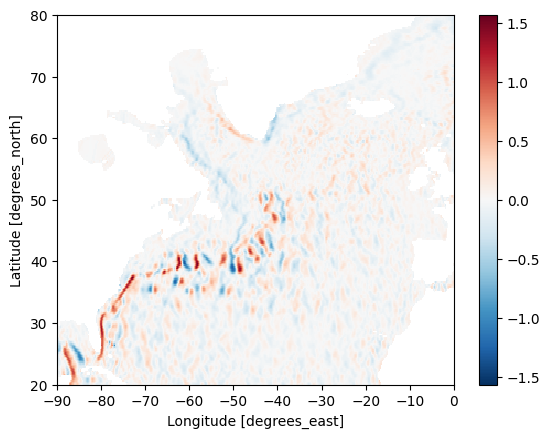

In [ ]:
vg.sel(xh=slice(-90, 0), yh=slice(20, 80)).isel(time=-1).plot()

In [ ]:
ZBssh = ZBh.interp(xh=obs.xh, yh=obs.yh)
lores_ssh = loresh.interp(xh=obs.xh, yh=obs.yh)

In [ ]:
ZBug, ZBvg = geostrophic_velocity(obs, ZBssh)
loresug, loresvg = geostrophic_velocity(obs, lores_ssh)

In [ ]:
ZBkeg = (ZBug**2 + ZBvg**2) * 0.5
loreskeg = (loresug**2 + loresvg**2) * 0.5
obskeg = (ug**2 + vg**2) * 0.5

ZBkeg["time"] = ZBh["time"]
loreskeg["time"] = loresh["time"]
obskeg["time"] = obs["time"]

In [ ]:
ZBuint = ZBu.interp(xq=obs.xh, yh=obs.yh)
ZBvint = ZBv.interp(xh=obs.xh, yq=obs.yh)

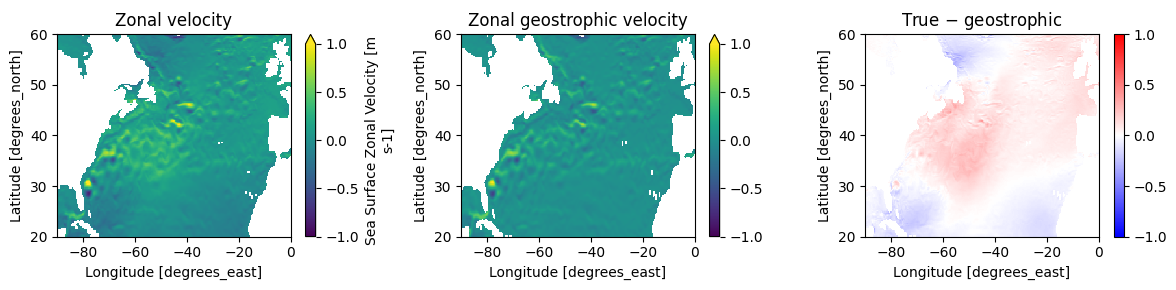

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
ZBuint.sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(vmin=-1, vmax=1)
plt.title("Zonal velocity")
plt.subplot(1, 3, 2)
ZBug.sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(vmin=-1, vmax=1)
plt.title("Zonal geostrophic velocity")
plt.subplot(1, 3, 3)
(ZBuint - ZBug).sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(
    vmin=-1, vmax=1, cmap="bwr"
)
plt.title("True $-$ geostrophic")
plt.tight_layout()

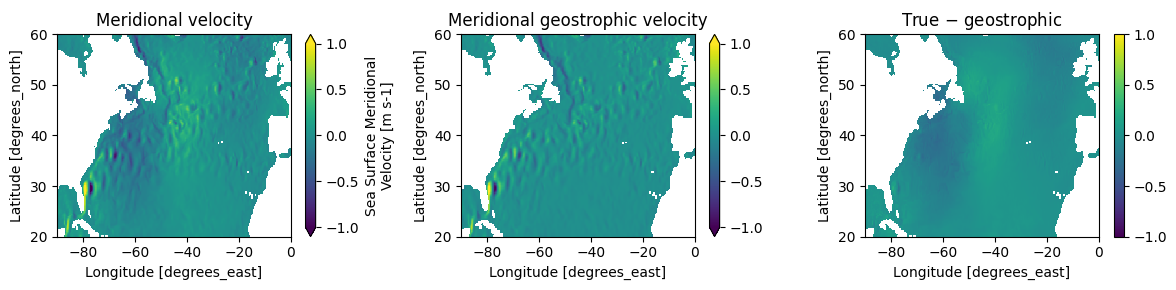

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
ZBvint.sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(vmin=-1, vmax=1)
plt.title("Meridional velocity")
plt.subplot(1, 3, 2)
ZBvg.sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(vmin=-1, vmax=1)
plt.title("Meridional geostrophic velocity")
plt.subplot(1, 3, 3)
(ZBvint - ZBvg).sel(xh=slice(-90, 0), yh=slice(20, 60)).isel(time=-1).plot(
    vmin=-1, vmax=1
)
plt.title("True $-$ geostrophic")
plt.tight_layout()

# Plotting KE

In [ ]:
OBS_vg = np.sqrt(2 * obskeg.isel(time=slice(5478, 7305)))
ZB_vg = np.sqrt(2 * ZBkeg)
LORES_vg = np.sqrt(2 * loreskeg)

In [ ]:
default_rcParams({"figure.subplot.wspace": 0.1, "font.size": 20})


def plot_regions(idx=0, lat=slice(20, 70), lon=slice(-90, 0)):
    fig, axes = plt.subplots(
        1,
        3,
        figsize=(12, 4),
        subplot_kw={
            "projection": ccrs.Orthographic(
                central_latitude=(lat.start + lat.stop) / 2,
                central_longitude=(lon.start + lon.stop) / 2,
            )
        },
    )

    time_idx = idx
    time_str = LORES_vg.time.isel(time=time_idx).item().strftime("%Y-%m-%d")

    # My preset; Equivalent to plotting surface KE
    cmap = plt.get_cmap("inferno")
    norm = mpl.colors.LogNorm(vmin=0.05, vmax=1.5)
    # Julius preset
    # cmap = plt.get_cmap('BuPu')
    # norm = mpl.colors.LogNorm(vmin=10**(-1.5), vmax=10**(0.5))
    cmap.set_bad("gray")

    ax = axes[0]
    ax.coastlines()
    ax.gridlines()
    im = (
        LORES_vg.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            norm=norm,
            cmap=cmap,
            add_colorbar=False,
        )
    )
    ax.set_title("OM4 ($1/4^o$)", fontsize=30)

    ax = axes[1]
    ax.coastlines()
    ax.gridlines()
    im = (
        ZB_vg.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            norm=norm,
            cmap=cmap,
            add_colorbar=False,
        )
    )
    ax.set_title("ZB20", fontsize=30)

    ax = axes[2]
    ax.coastlines()
    ax.gridlines()
    im = (
        OBS_vg.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            norm=norm,
            cmap=cmap,
            add_colorbar=False,
        )
    )
    ax.set_title("Altimetry", fontsize=30)

    cb = plt.colorbar(
        im,
        pad=0.02,
        ax=axes,
        extend="both",
        aspect=100,
        shrink=1.0,
        orientation="horizontal",
    )
    cb.set_label(label="Surface geostrophic velocity, $\mathrm{m}/\mathrm{s}$")
    plt.suptitle(time_str, y=0.95)

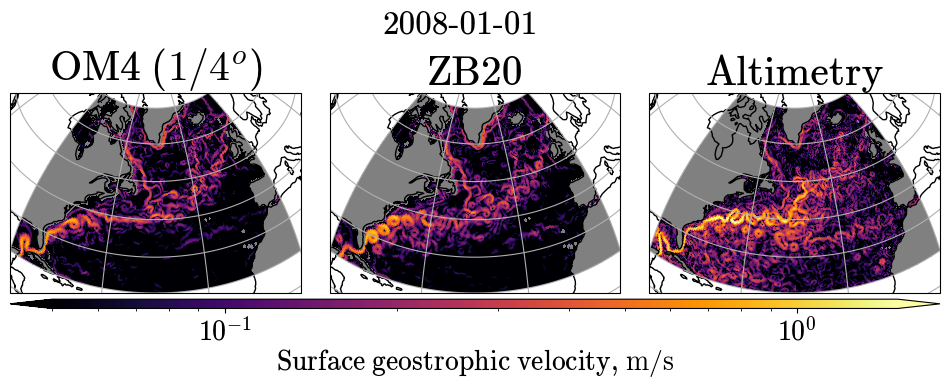

In [ ]:
plot_Atlantic = lambda idx: plot_regions(idx=idx)
plot_Atlantic(0)

In [ ]:
%%time
create_animation(
    plot_Atlantic,
    range(0, 1827, 3),
    "site-visit/geovel.gif",
    deezering=False,
    dpi=300,
    FPS=20,
)

Animation at FPS=20 will last for 30.45 seconds
CPU times: user 19min 6s, sys: 11min 14s, total: 30min 21s
Wall time: 17min 38s


In [ ]:
split_gif("site-visit/geovel.gif", "site-visit/geovel", 5)

Segment 0 saved as site-visit/geovel/segment_0.gif
Segment 1 saved as site-visit/geovel/segment_1.gif
Segment 2 saved as site-visit/geovel/segment_2.gif
Segment 3 saved as site-visit/geovel/segment_3.gif
Segment 4 saved as site-visit/geovel/segment_4.gif
Split site-visit/geovel.gif into 5 segments
